In [ ]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.base import clone
from pickle import dump
import xgboost as xgb


In [ ]:
## Load the dataset
df = pd.read_csv('../data/dataset/dataset.csv')
df.head()

In [ ]:
df.tail()

In [ ]:
## Drop the columns that are not needed
df.drop("year", axis=1, inplace=True)

In [ ]:
def class_maper(score):
    if score == 0:
        return 0  # Draw
    elif score > 0:
        return 1   # Home win
    elif score < 0:
        return 2   # Away Win
    

In [ ]:
## Split the dataset into train and test
from sklearn.model_selection import train_test_split

X = df.drop('net_score', axis=1)
y = df['net_score'].apply(class_maper)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [ ]:
le = preprocessing.LabelEncoder()

fifa2022_countries = pd.read_csv("../data/world_cup_2022_data/groups_of_2022.csv")["country"].values.tolist()
countries_set = set(list(X["2nd_team"]) + list(X["1st_team"]) + fifa2022_countries)

countries_encoder = le.fit(list(countries_set))
dump(countries_encoder, open('../models/encoders/countries_encoder.pkl', 'wb'))

X_train["2nd_team"] = countries_encoder.transform(X_train["2nd_team"])
X_train["1st_team"] = countries_encoder.transform(X_train["1st_team"])

X_test["2nd_team"] = countries_encoder.transform(X_test["2nd_team"])
X_test["1st_team"] = countries_encoder.transform(X_test["1st_team"])

In [ ]:
## Apply PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pca = PCA(n_components=0.9)
scaler = StandardScaler()



In [ ]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression


estimators_dict = {
xgb.XGBClassifier():
{
    "est__n_estimators": [ 200, 500, 1500],
    "est__booster": ["gbtree", "gblinear"],
    "est__eta": [0.01, 0.1, 1.0],
    "est__alpha": [0, 0.5, 1],
    "est__lambda": [0, 1 , 2]

},
RandomForestClassifier():  
{
    "est__n_estimators": [10, 50, 100, 200, 500],
    "est__max_depth": [3, 5, 10, 20, 55],
    "est__min_samples_split": [2, 5, 10],
    "est__min_samples_leaf": [1, 2, 4],
    "est__bootstrap": [True, False],
    "est__criterion": ["gini", "entropy"]
},
AdaBoostClassifier():
{
    "est__n_estimators": [10, 50, 100, 200, 500],
    "est__learning_rate": [0.01, 0.05, 0.1, 0.5, 1.0],
    "est__algorithm": ["SAMME", "SAMME.R"]
},
# GradientBoostingClassifier():
# {
#     "est__loss": ["log_loss", "exponential"],
#     "est__learning_rate": [0.01, 0.05, 0.1, 0.5, 1.0],
#     "est__n_estimators": [10, 50, 100, 200, 500],
#     "est__max_depth": [3, 5, 10, 20, 50, 100, None],
#     "est__min_samples_split": [2, 5, 10],
#     "est__min_samples_leaf": [1, 2, 4],
#     "est__criterion": ["friedman_mse", "mse", "mae"]
# },
KNeighborsClassifier():
{
    "est__n_neighbors": [3, 5, 10, 20, 50, 100],
    "est__weights": ["uniform", "distance"],
    "est__algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
    "est__leaf_size": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
},
# SVC():
# {
#     "est__C": [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
#     "est__kernel": ["linear", "poly", "rbf", "sigmoid"],
#     "est__degree": [2, 3, 4, 5, 6, 7, 8, 9, 10],
#     "est__gamma": ["scale", "auto"],
#     "est__shrinking": [True, False]
# },
LogisticRegression():
{
    "est__penalty": ["l1", "l2"],
    "est__C": [0.1, 0.5, 1.0, 5.0, 10.0, 50.0, 100.0],
    "est__solver": ["newton-cg", "liblinear", "sag", "saga"],
    "est__max_iter": [100, 200, 500, 1000, 2000, 5000, 10000]
}


}


In [ ]:
from sklearn.model_selection import GridSearchCV

def get_best_estimator(estimator, params, cv):
    grid = GridSearchCV(estimator, params, cv=cv, scoring="neg_mean_squared_error", n_jobs=-1)
    grid.fit(X_train, y_train)
    return grid.best_estimator_


In [11]:
### Get tunned pipeline
from sklearn.model_selection import cross_validate, KFold

scorers = ["f1_micro"]
train_f1_micro = "train_f1_micro"
test_f1_micro = "test_f1_micro"

cv = KFold(n_splits=5, shuffle=True, random_state=42)

valid_results = pd.DataFrame(columns=["estimator", "params", "train_f1_micro", "test_f1_micro"])    

                                      
for est, params in estimators_dict.items():
    print("Getting best estimator for {}".format(est))
    pipeline = Pipeline(steps=[('scaler', scaler), ('pca', pca), ('est', est)])
    tunned_estimator = get_best_estimator(pipeline, params, cv)

    
    scores = cross_validate(tunned_estimator, X_train, y_train, cv=cv, return_train_score=True, scoring=scorers, n_jobs=-1)
    valid_results = valid_results.append({
        "estimator": tunned_estimator,
        "params": tunned_estimator.get_params(),
        train_f1_micro: scores["train_f1_micro"].mean(),
        test_f1_micro: scores["test_f1_micro"].mean(),
    }, ignore_index=True)

valid_results

/Users/zghazal/opt/miniconda3/envs/fifa_env/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/var/folders/f_/j35gcy5525j927nvg0qt9v9c0000gn/T/ipykernel_1526/3465531274.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_results = valid_results.append({


Getting best estimator for RandomForestClassifier()


/var/folders/f_/j35gcy5525j927nvg0qt9v9c0000gn/T/ipykernel_1526/3465531274.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_results = valid_results.append({


Getting best estimator for AdaBoostClassifier()


/var/folders/f_/j35gcy5525j927nvg0qt9v9c0000gn/T/ipykernel_1526/3465531274.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_results = valid_results.append({


Getting best estimator for KNeighborsClassifier()


/var/folders/f_/j35gcy5525j927nvg0qt9v9c0000gn/T/ipykernel_1526/3465531274.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  valid_results = valid_results.append({


Getting best estimator for LogisticRegression()


/Users/zghazal/opt/miniconda3/envs/fifa_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zghazal/opt/miniconda3/envs/fifa_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zghazal/opt/miniconda3/envs/fifa_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zghazal/opt/miniconda3/envs/fifa_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/zghazal/opt/miniconda3/envs/fifa_env/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_

,estimator,params,train_f1_micro,test_f1_micro
0,"(StandardScaler(), PCA(n_components=0.9), XGBC...","{'memory': None, 'steps': [('scaler', Standard...",0.547533,0.494853
1,"(StandardScaler(), PCA(n_components=0.9), (Dec...","{'memory': None, 'steps': [('scaler', Standard...",0.551475,0.483301
2,"(StandardScaler(), PCA(n_components=0.9), (Dec...","{'memory': None, 'steps': [('scaler', Standard...",0.515762,0.486437
3,"(StandardScaler(), PCA(n_components=0.9), KNei...","{'memory': None, 'steps': [('scaler', Standard...",0.451423,0.448636
4,"(StandardScaler(), PCA(n_components=0.9), Logi...","{'memory': None, 'steps': [('scaler', Standard...",0.548061,0.500110


In [12]:
X["1st_team"] = countries_encoder.transform(X["1st_team"])
X["2nd_team"] = countries_encoder.transform(X["2nd_team"])


In [13]:
for model in valid_results["estimator"].values:
    model = clone(model)
    print(model)
    model.fit(X, y)
    dump(model, open("../models/classification/{}.pkl".format(model["est"].__class__.__name__), "wb"))
    


Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA(n_components=0.9)),
                ('est',
                 XGBClassifier(alpha=1, base_score=0.5, booster='gblinear',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eta=0.01,
                               eval_metric=None, feature_types=None, gamma=None,
                               gpu_id=-1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, lambda=0,
                               learning_rate=0.5, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=None,
                               max_leaves=None, min_child_weight=None,
 

In [14]:
# Test clssifiers on test data

from sklearn.metrics import f1_score

test_results = pd.DataFrame(columns=["estimator", "params", "test_f1_micro"])

for model in valid_results["estimator"].values:
    model = clone(model)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    test_results = test_results.append({
        "estimator": model,
        "params": model.get_params(),
        "test_f1_micro": f1_score(y_test, y_pred, average="micro")
    }, ignore_index=True)

/var/folders/f_/j35gcy5525j927nvg0qt9v9c0000gn/T/ipykernel_1526/3408892729.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_results = test_results.append({
/var/folders/f_/j35gcy5525j927nvg0qt9v9c0000gn/T/ipykernel_1526/3408892729.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_results = test_results.append({
/var/folders/f_/j35gcy5525j927nvg0qt9v9c0000gn/T/ipykernel_1526/3408892729.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_results = test_results.append({
/var/folders/f_/j35gcy5525j927nvg0qt9v9c0000gn/T/ipykernel_1526/3408892729.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  test_results = test_r

XGBClassifier


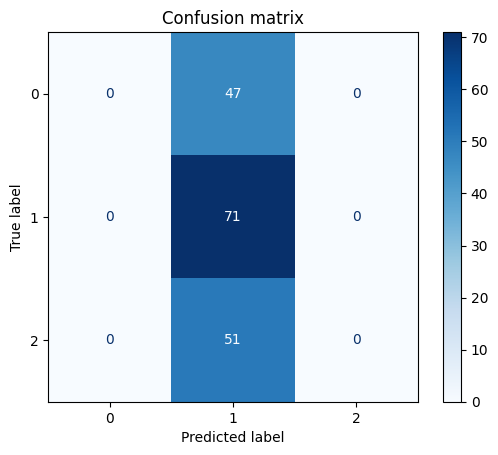

RandomForestClassifier


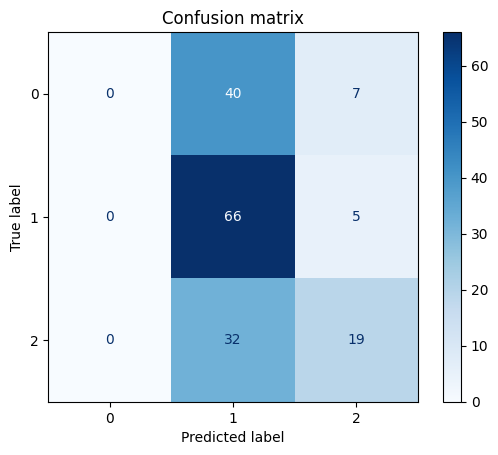

AdaBoostClassifier


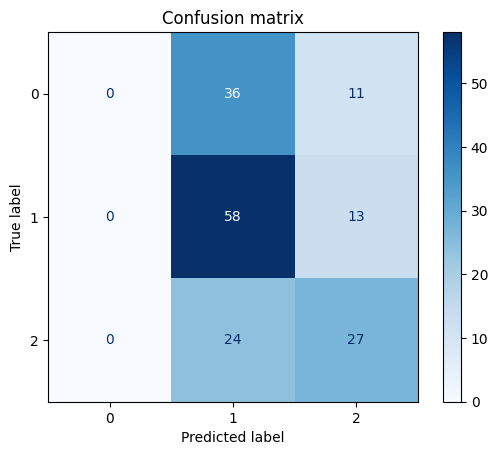

KNeighborsClassifier


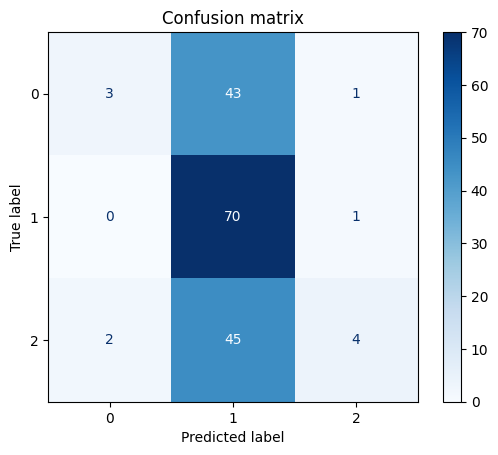

LogisticRegression


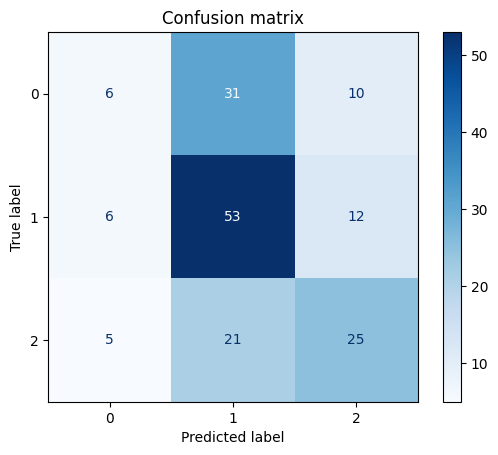

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
for model in valid_results["estimator"].values:
    print(model["est"].__class__.__name__)
    disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        # display_labels=class_names,
        cmap=plt.cm.Blues,
    )
    disp.ax_.set_title("Confusion matrix")
    plt.show()
    

    # print(disp.confusion_matrix)



In [40]:
probs = valid_results["estimator"].values[-1].predict_proba(X_test)[2]
prediction = valid_results["estimator"].values[-1].predict(X_test)[2]

if prediction == 0:
    print("Draw")
elif prediction == 1:
    print("1st team win")
elif prediction == 2:
    print("2nd team win")

team_1_winning_prob = np.round(probs[2], 2)*100
team_2_winning_prob = np.round(probs[1], 2)*100
draw_prob = np.round(probs[0], 2)*100

print("1st team winning prob: {}%".format(team_1_winning_prob))
print("2nd team winning prob: {}%".format(team_2_winning_prob))
print("Draw prob: {}%".format(draw_prob))

1st team win
1st team winning prob: 15.0%
2nd team winning prob: 43.0%
Draw prob: 42.0%


In [32]:
valid_results["estimator"].values[-1].predict(X_test)[2]

1

In [24]:
valid_results["estimator"].values[-1].classes_

array([0, 1, 2])